In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def lennard_jones_potential(r, sigma: float, eps: float) -> np.ndarray:
    return 4*eps*np.power(sigma, 12)/np.power(r, 12) - 4*eps*np.power(sigma, 6)/np.power(r, 6)

def lennard_jones_force(r, sigma: float, eps: float) -> np.ndarray:
    return 24*eps*np.power(sigma, 6)/np.power(r, 7) - 48*eps*np.power(sigma, 12)/np.power(r, 13)

def get_kinetic_energy(m, v):
    return m*(v**2)/2

def get_verlet_next_x(x, v, f, m, dt):
    a = f/m
    return x + v*dt + a*(dt**2)/2

def get_verlet_next_f(rs, sigma: float, eps: float):
    return np.sum(lennard_jones_force(rs, sigma, eps))

def get_verlet_next_v(v, f, f_next, m, dt):
    a, a_next = f/m, f_next/m
    return v + ((a + a_next)*dt)/2

In [20]:
# %% Parameters
SIGMA = 1
EPS = 1.5
M1 = 1
M2 = 2
SIMULATION_TIME = 7

# %% Initial Conditions
X1_0 = 10
X2_0 = 12
V1_0 = 0
V2_0 = 0

# %% Tuple Indexes
I_X1, I_X2, I_V1, I_V2, I_F1, I_F2 = 0, 1, 2, 3, 4, 5
I_U, I_EK1, I_EK2, I_ET, I_T = 6, 7, 8, 9, 10

In [37]:
def verlet_pair_next(x1, x2, v1, v2, f1, f2, m1, m2, dt, sigma, eps):
    x1_next = get_verlet_next_x(x1, v1, f1, m1, dt)
    x2_next = get_verlet_next_x(x2, v2, f2, m2, dt)
    
    f1_next = get_verlet_next_f(np.array([x2_next-x1_next]), sigma, eps)
    f2_next = get_verlet_next_f(np.array([x1_next-x2_next]), sigma, eps)
    
    v1_next = get_verlet_next_v(v1, f1, f1_next, M1, dt)
    v2_next = get_verlet_next_v(v2, f2, f2_next, M2, dt)
    
    u_next = lennard_jones_potential(x2_next-x1_next, sigma, eps)
    ek1_next = get_kinetic_energy(m1, v1_next)
    ek2_next = get_kinetic_energy(m2, v2_next)
    et_next = u_next + ek1_next + ek2_next
    
    return x1_next, x2_next, v1_next, v2_next, f1_next, f2_next, u_next, ek1_next, ek2_next, et_next

In [38]:
def verlet_algo(simulation_time, dt, sigma, eps):
    time = np.arange(0, simulation_time + dt, dt)

    x1 = [X1_0]
    x2 = [X2_0]

    v1 = [V1_0]
    v2 = [V2_0]

    f1 = [lennard_jones_force(X2_0-X1_0, sigma, eps)]
    f2 = [lennard_jones_force(X1_0-X2_0, sigma, eps)]

    u = [lennard_jones_potential(X2_0-X1_0, sigma, eps)]
    ek1 = [get_kinetic_energy(M1, V1_0)]
    ek2 = [get_kinetic_energy(M2, V2_0)]
    et = [u[0] + ek1[0] + ek2[0]]

    for curr in range(len(time) - 1):
        x1_next, x2_next, v1_next, v2_next, f1_next, f2_next, u_next, ek1_next, ek2_next, et_next \
            = verlet_pair_next(x1[curr], x2[curr], v1[curr], v2[curr], f1[curr], f2[curr], M1, M2, dt, sigma, eps)
        
        # получим следующие координаты
        x1.append(x1_next)
        x2.append(x2_next)

        # получим следующие значения силы и ускорений из следующих координат
        f1.append(f1_next)
        f2.append(f2_next)

        # получим следующие значения скоростей
        v1.append(v1_next)
        v2.append(v2_next)

        # получим следующее значение потенциала
        u.append(u_next)

        # получим следующие значения кинетических энергий частиц
        ek1.append(ek1_next)
        ek2.append(ek2_next)

        # получим следующее значение полной энергии системы (почему потенциал берем один раз?)
        et.append(et_next)

    return x1, x2, v1, v2, f1, f2, u, ek1, ek2, et, time

In [39]:
delta_t = 0.01

data = verlet_algo(SIMULATION_TIME, delta_t, SIGMA, EPS)

time = data[I_T]

x1_verlet = data[I_X1]
x2_verlet = data[I_X2]

v1_verlet = data[I_V1]
v2_verlet = data[I_V2]

total_energy_verlet = data[I_ET]
potential_verlet = data[I_U]
energy_kinetic1_verlet = data[I_EK1]
energy_kinetic2_verlet = data[I_EK2]

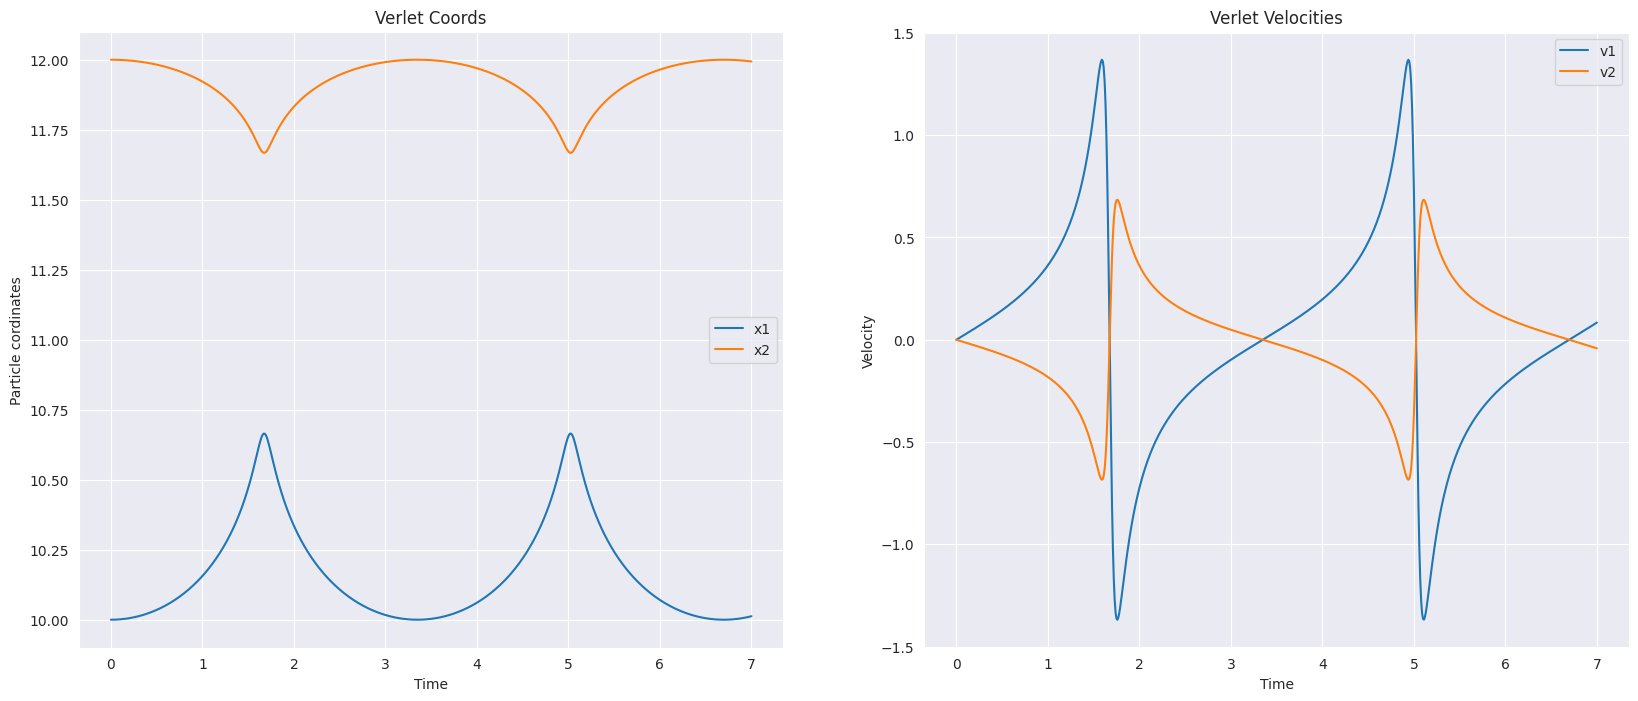

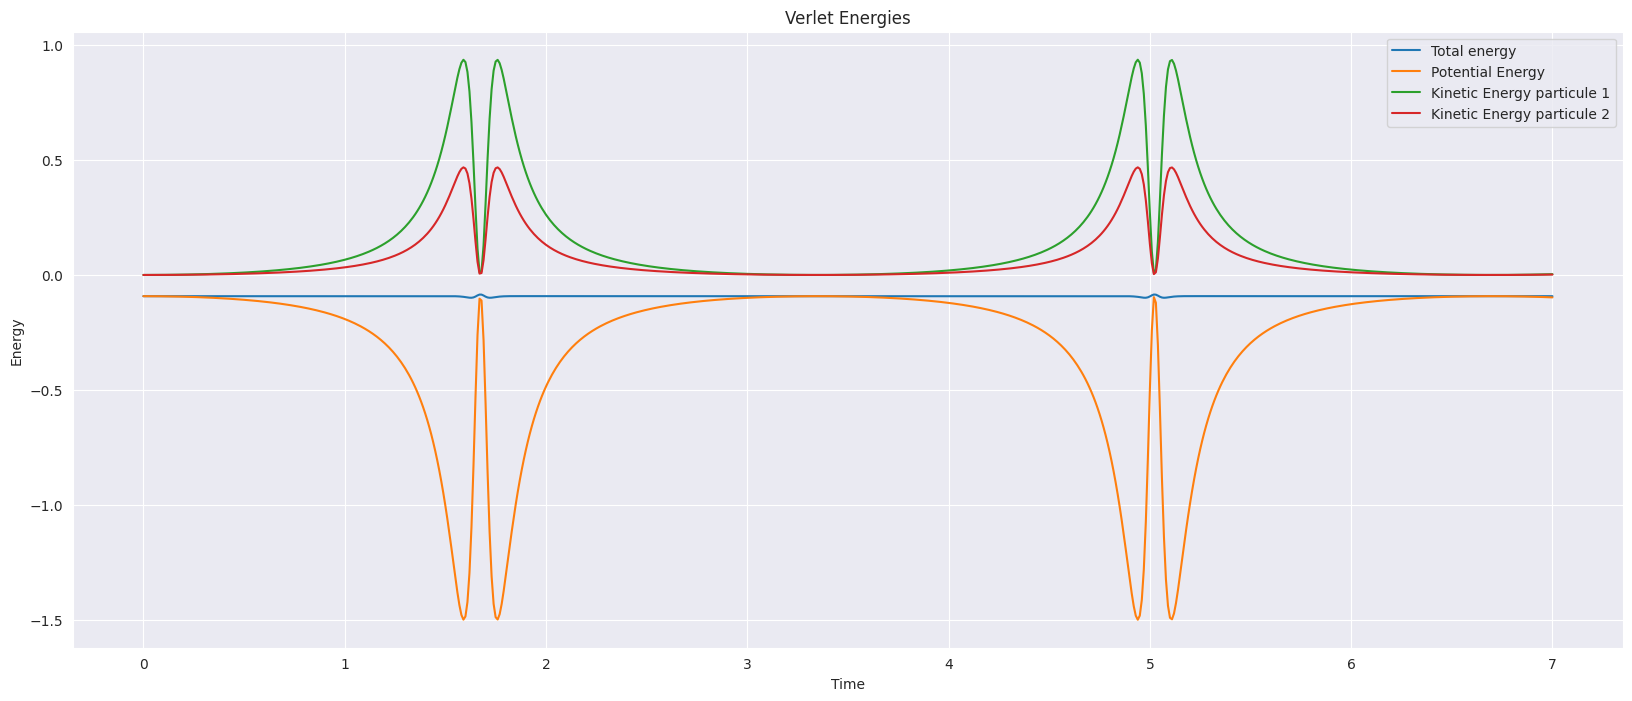

In [40]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=x1_verlet,
    ax=axes[0],
    label='x1',
)
sns.lineplot(
    x=time,
    y=x2_verlet,
    ax=axes[0],
    label='x2',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=v1_verlet,
    ax=axes[1],
    label='v1',
)
sns.lineplot(
    x=time,
    y=v2_verlet,
    ax=axes[1],
    label='v2',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=total_energy_verlet,
    ax=ax,
    label='Total energy',
)
sns.lineplot(
    x=time,
    y=potential_verlet,
    ax=ax,
    label='Potential Energy',
)
sns.lineplot(
    x=time,
    y=energy_kinetic1_verlet,
    ax=ax,
    label='Kinetic Energy particule 1',
)
sns.lineplot(
    x=time,
    y=energy_kinetic2_verlet,
    ax=ax,
    label='Kinetic Energy particule 2',
)
plot.set_xlabel('Time')
plot.set_ylabel('Energy')
plot.set_title("Verlet Energies");